In [1]:
import torch
import numpy as np

In [2]:
from InteractionNetwork import InteractionNetwork

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.colors as colors

In [5]:
model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

<All keys matched successfully>

In [6]:
import yaml
from GraphDataset import GraphDataset


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']


file_names=["/teams/DSC180A_FA20_A00/b06particlephysics/train/ntuple_merged_10.root"]
graph_dataset = GraphDataset('data', features, labels, spectators, n_events=10000, n_events_merge=1000, 
                             file_names=file_names)

In [7]:
b=graph_dataset[0]
g=b[0]
g.batch=torch.tensor(np.zeros(g.x.shape[0]).astype("int64"))
g

Data(batch=[38], edge_index=[2, 1406], u=[1, 2], x=[38, 48], y=[1, 2])

# extract intermediate activation and gradient with hook

In [319]:
def hook(dest,key,idx=0,row=None):        
    def forward_hook(model,input,output):
        a=input[0].detach()
        a.requires_grad=True
        a.retain_grad()
        inputs[key]=a
        m[key]=model
        
        def f(R,rho=lambda x:x,model=model,epsilon=1e-9):   
            if not (row is None):
                R=R[row,idx:]
            else:
                R=R[:,idx:]
            z=epsilon+rho(model).forward(a)
            s=R/(z+1e-9)
            (z*s.data).sum().backward()
            c=a.grad
            R=(a*c)
            return R
        
        dest.append((key,f))
    
        
    return forward_hook

In [324]:
A=[]
inputs={}
hooks={}
R={}
m={}

model=InteractionNetwork()
model.load_state_dict(torch.load("../data/model/IN_best_dec10.pth"))

for i in (model.interactionnetwork.children()):
    for n,j in i.named_modules():
        if n and n[-1].isnumeric() and ("." in n):
            # special cases: split before node 1.3 and edge 3
            print(n)
            if n=="node_mlp_1.3":
                h=j.register_forward_hook(hook(A,n,48,g.edge_index[0]))
            elif n=="edge_mlp.3":
                h=j.register_forward_hook(hook(A,n,48))
            else:
                h=j.register_forward_hook(hook(A,n))
                
            hooks[n]=h

edge_mlp.0
edge_mlp.1
edge_mlp.2
edge_mlp.3
node_mlp_1.0
node_mlp_1.1
node_mlp_1.2
node_mlp_1.3
node_mlp_2.0
node_mlp_2.1
node_mlp_2.2
node_mlp_2.3
global_mlp.0
global_mlp.1
global_mlp.2
global_mlp.3


**todo**: what to do with the special layers, e.g. Batch norm?
- remove them from the computation of relevance?
- treat them as normal layers?

prev:
- skipping the special layers-> doesn't look right

current:
- combine batch norm layer and relu with previous linear layer-> combine the three layers into a Sequential container

In [326]:
model.eval()
out=model(g.x,g.edge_index,g.batch)

In [311]:
from torch.nn import Sequential as Seq

In [327]:
[n for n,_ in A]

['edge_mlp.0',
 'edge_mlp.1',
 'edge_mlp.2',
 'edge_mlp.3',
 'node_mlp_1.0',
 'node_mlp_1.1',
 'node_mlp_1.2',
 'node_mlp_1.3',
 'node_mlp_2.0',
 'node_mlp_2.1',
 'node_mlp_2.2',
 'node_mlp_2.3',
 'global_mlp.0',
 'global_mlp.1',
 'global_mlp.2',
 'global_mlp.3']

In [329]:
special_layers=["edge_mlp.1","edge_mlp.2",
          "node_mlp_1.1","node_mlp_1.2",
          "node_mlp_2.1","node_mlp_2.2",
          "global_mlp.1","global_mlp.2"]

In [330]:
n,f=A.pop()
R[n]=f(out)
n_prev=n
layers=[]
while len(A):
    n,f=A.pop()
    hooks[n].remove()
    print(n)
    
    if n in special_layers:
        print(f"    special layer {n}")
        layers.append(m[n])
    elif len(layers):
        print(f"    joint layer {n}")
        layers.append(m[n])
        R[n]=f(R[n_prev],model=Seq(*layers[::-1]))
        layers=[]
        n_prev=n
    else:
        print(f"    normal layer {n}")
        R[n]=f(R[n_prev])
        n_prev=n

global_mlp.2
    special layer global_mlp.2
global_mlp.1
    special layer global_mlp.1
global_mlp.0
    joint layer global_mlp.0
node_mlp_2.3
    normal layer node_mlp_2.3
node_mlp_2.2
    special layer node_mlp_2.2
node_mlp_2.1
    special layer node_mlp_2.1
node_mlp_2.0
    joint layer node_mlp_2.0
node_mlp_1.3
    normal layer node_mlp_1.3
node_mlp_1.2
    special layer node_mlp_1.2
node_mlp_1.1
    special layer node_mlp_1.1
node_mlp_1.0
    joint layer node_mlp_1.0
edge_mlp.3
    normal layer edge_mlp.3
edge_mlp.2
    special layer edge_mlp.2
edge_mlp.1
    special layer edge_mlp.1
edge_mlp.0
    joint layer edge_mlp.0


In [332]:
R

{'global_mlp.3': tensor([[ 0.0103,  0.0000, -0.0516, -0.0000,  0.0032, -0.0000,  0.0000,  0.0409,
           0.0000, -0.0086, -0.0000,  0.0000, -0.0000, -0.0276, -0.0694, -0.0055,
           0.0012,  0.0077, -0.0000, -0.0000,  0.0045,  0.0099,  0.0438,  0.0587,
           0.0000, -0.0107,  0.0000,  0.0000,  0.0615,  0.0022, -0.0257,  0.0000,
           0.0804,  0.0033,  0.0208,  0.0000, -0.1419, -0.0225,  0.0923, -0.0000,
           0.1032,  0.0576,  0.0980,  0.0288, -0.0000, -0.0000, -0.0000, -0.0059,
          -0.0057, -0.0381, -0.1762,  0.0000,  0.0483,  0.0014,  0.0000, -0.0159,
           0.0340,  0.0922, -0.0390, -0.0000,  0.0000, -0.0156,  0.0036, -0.0165,
           0.0000,  0.0189,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0513,
           0.0003,  0.0000, -0.0051, -0.0520,  0.0000,  0.0698,  0.0000,  0.0003,
           0.0000,  0.0000,  0.0000, -0.0000,  0.0354,  0.0208,  0.0102, -0.0236,
           0.0000, -0.0000,  0.0000, -0.0000, -0.0074,  0.0000, -0.0201, -0.0250,


In [344]:
R["edge_mlp.0"].shape

torch.Size([1406, 96])

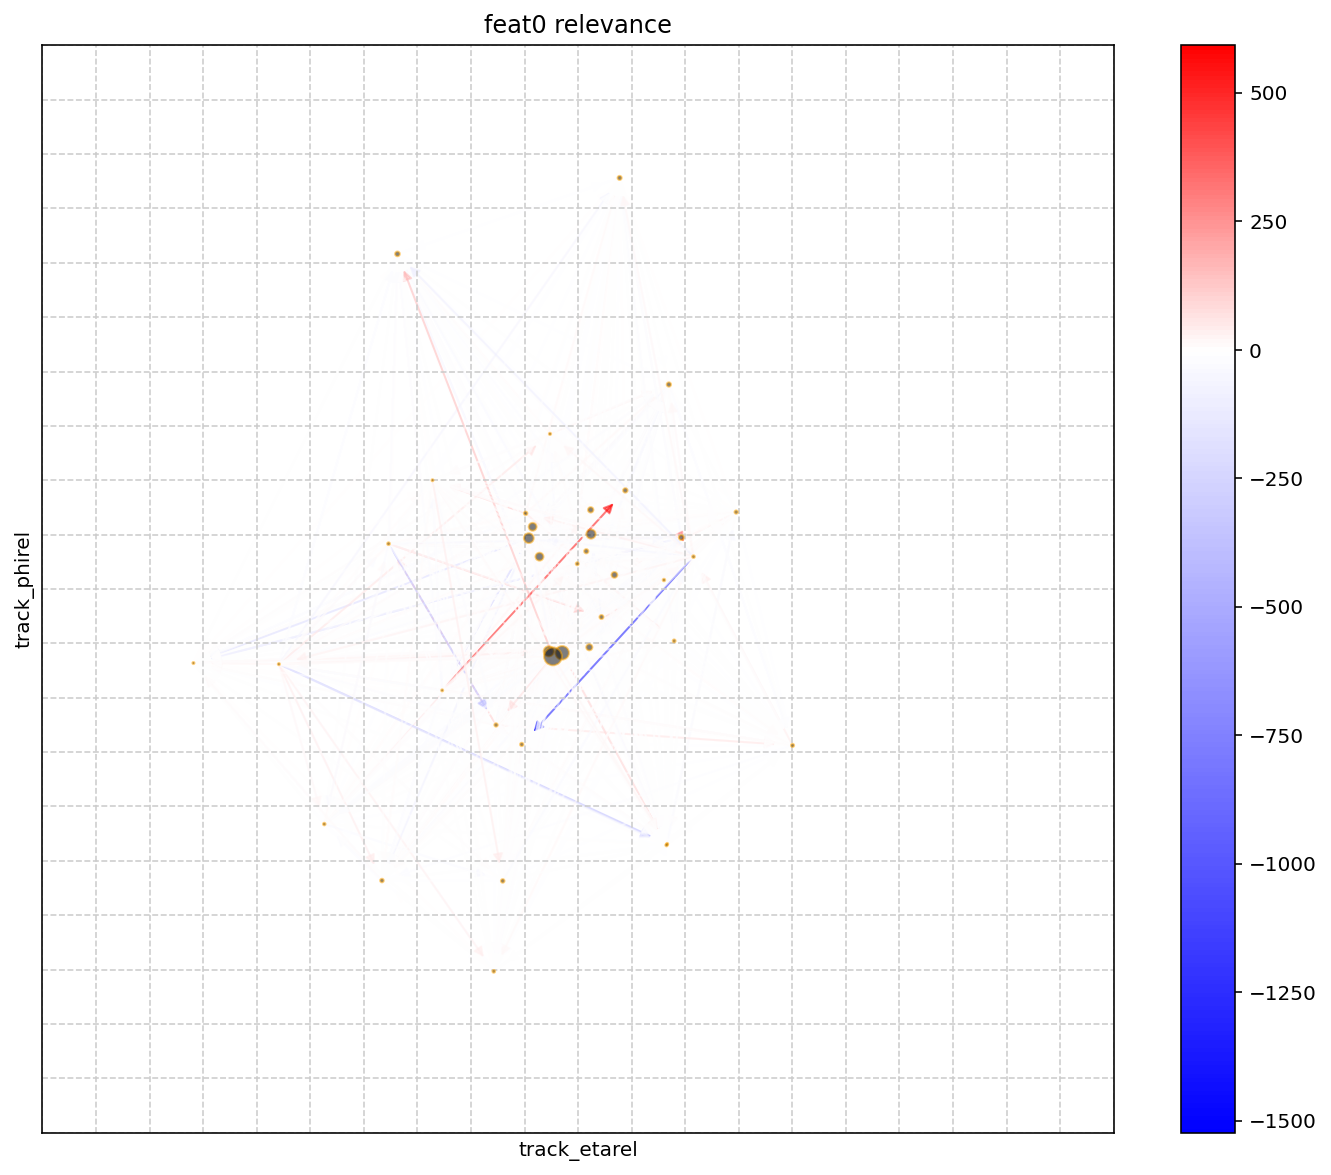

In [339]:
plot_rel(0,g,R["edge_mlp.0"].detach().numpy())

TODO: 
- proper way to aggregate the src/dest relevance (R has shape n_edges by (48 * 2))?

current:
- plotting just the src part

<hr>

# previous work [discard]

average feature contribution

In [96]:
row,col=g.edge_index
row

tensor([ 0,  0,  0,  ..., 37, 37, 37])

In [97]:
ix=[np.searchsorted(row,i).item() for i in range(38)]

L1 norm * sign(mean relevance))

<BarContainer object of 38 artists>

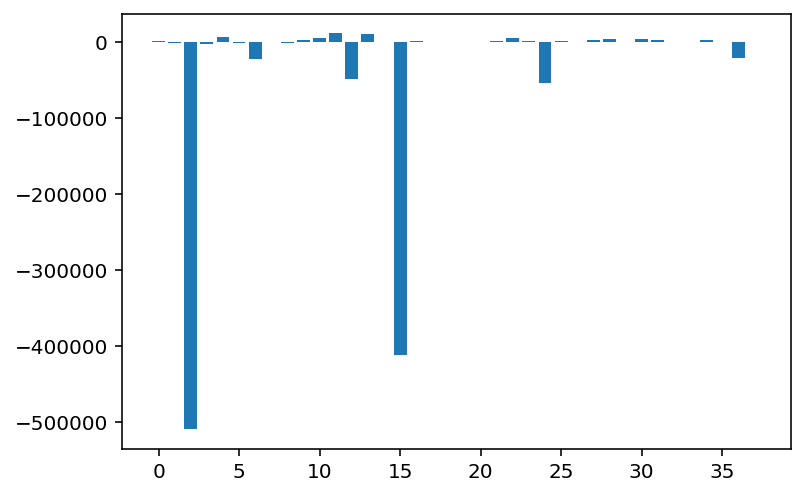

In [98]:
plt.bar(np.arange(38),np.linalg.norm(R["node_mlp_1.0"][ix,:48].detach().numpy(),1,axis=1)*np.sign(R["node_mlp_1.0"][ix,:48].detach().numpy().mean(axis=1)))

In [99]:
np.array(features)[[0,3,4,5,15,18,22,27,30]]

array(['track_pt', 'trackBTag_DeltaR', 'trackBTag_EtaRel',
       'trackBTag_JetDistVal', 'track_VTX_ass', 'track_detadeta',
       'track_dphidxy', 'track_dxy', 'track_dxysig'], dtype='<U20')

edge contribution

In [100]:
R["edge_mlp.0"]

tensor([[ 5.0322e+00, -5.1524e+00,  1.0155e+00,  ..., -1.4443e+01,
          4.4509e+01, -1.6281e-01],
        [ 4.9114e-01, -4.8836e-02, -1.4049e+00,  ..., -5.2666e-01,
         -2.1076e+00, -3.3239e-02],
        [ 2.9574e-01, -2.9853e-01,  2.0528e-01,  ..., -2.7458e-01,
          1.8954e+00,  1.2501e-02],
        ...,
        [-2.5467e+00,  5.7864e+01,  5.8052e+00,  ...,  1.1704e+01,
         -4.2632e+01,  3.2868e-01],
        [-3.3784e+01,  8.5780e+01, -1.1651e+02,  ..., -6.0566e+01,
          1.7305e+01,  3.0564e+00],
        [ 4.9140e-01, -3.1058e+01,  4.0995e+01,  ...,  9.6962e+01,
         -1.0381e+01, -2.2705e+00]], grad_fn=<MulBackward0>)

In [338]:
def plot_rel(idx,g,r0):
    r=r0[:,idx]
    offset=colors.TwoSlopeNorm(0,r.min(),r.max())

    fig, ax =plt.subplots(figsize=(12,10))

    pos=g.x[:,[eta_idx,phi_idx]].detach().numpy()
    G = to_networkx(g)

    nodes = nx.draw_networkx_nodes(G,pos,node_color='k',edgecolors="orange",alpha=0.5,
                                   with_labels=False,node_size=g.x[:,0].detach().cpu())
    edges0 = nx.draw_networkx_edges(G,pos,edge_color=offset(r),width=1,
                                   edge_cmap=plt.cm.bwr, arrows=True,alpha=0.5)


    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=offset)
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.axis([-1,1,-1,1])

    ax.xaxis.set_major_locator(MultipleLocator(1/10))
    ax.yaxis.set_major_locator(MultipleLocator(1/10))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')

    plt.grid(True)
    plt.xlabel("track_etarel")
    plt.ylabel("track_phirel")
    plt.title(f"feat{idx} relevance")
    plt.show()

# TODO:

threshold edges with close to 0 contribution in plotting.

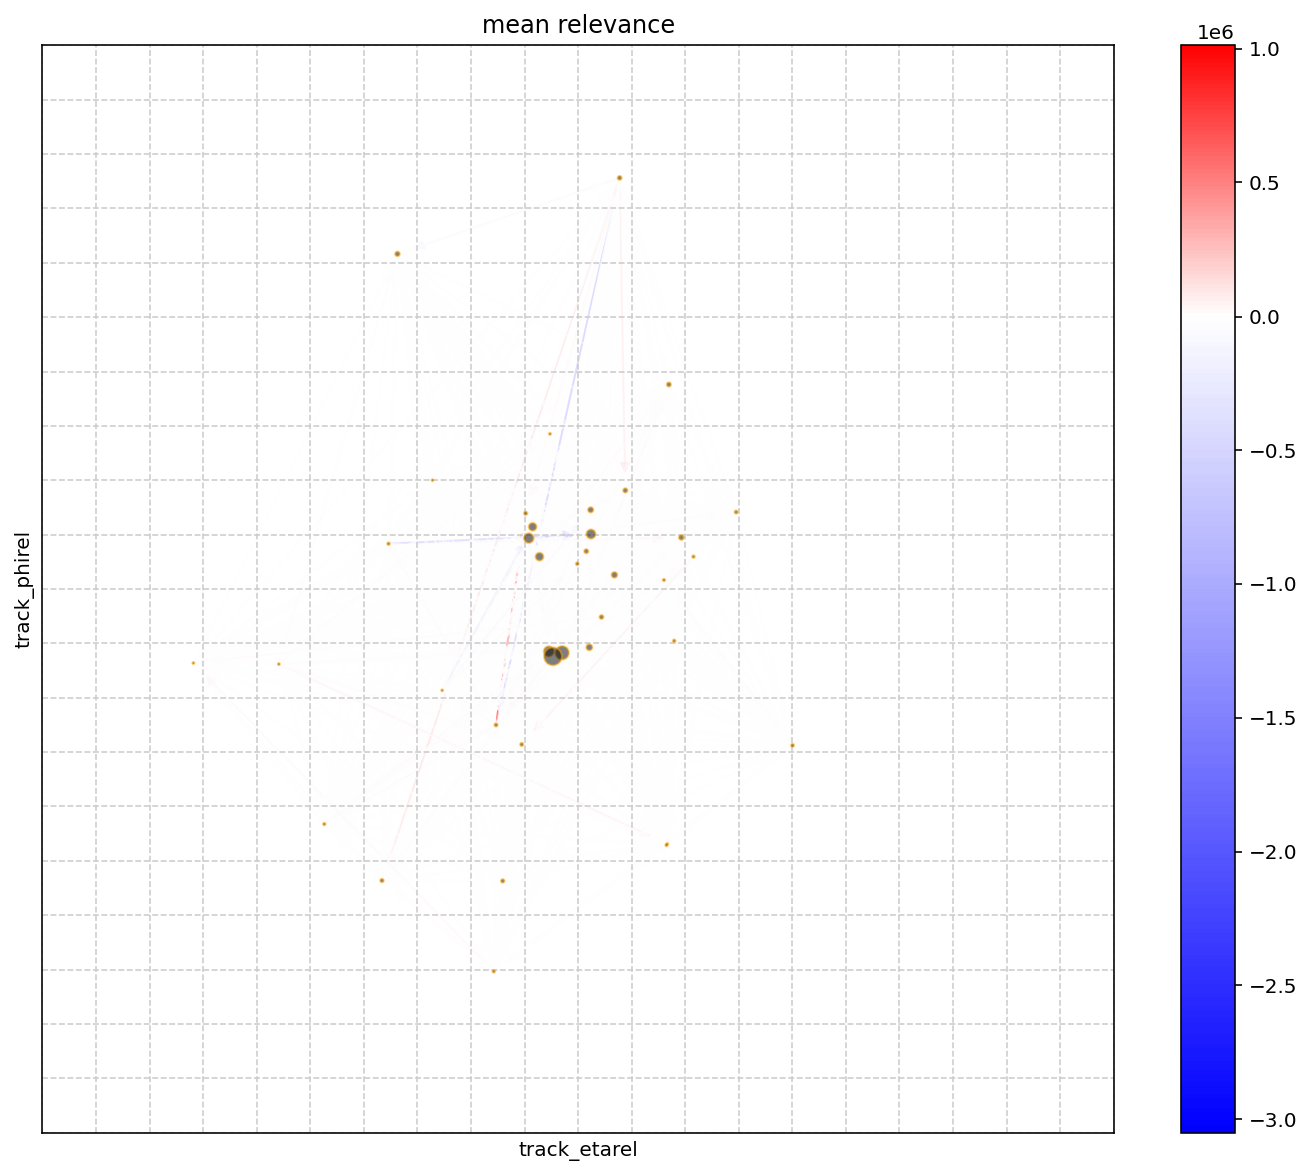

In [102]:
# initalize for plotting
activation=torch.nn.Softmax(1)
eta_idx,phi_idx=graph_dataset.features.index("track_etarel"),graph_dataset.features.index("track_phirel")


plot_rel(0,g,R["edge_mlp.0"].detach().numpy())

### WIP

In [103]:
g.edge_index

tensor([[ 0,  0,  0,  ..., 37, 37, 37],
        [ 1,  2,  3,  ..., 34, 35, 36]])

In [104]:
R["edge_mlp.0"].detach().numpy()[:,[0,48]]

array([[ 5.0321789e+00,  2.0237033e+00],
       [ 4.9114057e-01,  2.6623204e-01],
       [ 2.9574177e-01,  3.5743013e-02],
       ...,
       [-2.5467324e+00, -2.8245789e+01],
       [-3.3784229e+01, -6.4738464e+01],
       [ 4.9140015e-01,  2.2163862e+01]], dtype=float32)

In [105]:
def plot_rel(g,r0):
    r=r0[:,:48]-r0[:,48:]
    r=r.mean(axis=1)
    offset=colors.TwoSlopeNorm(0,r.min(),r.max())

    fig, ax =plt.subplots(figsize=(12,10))

    pos=g.x[:,[eta_idx,phi_idx]].detach().numpy()
    G = to_networkx(g)

    nodes = nx.draw_networkx_nodes(G,pos,node_color='k',edgecolors="orange",alpha=0.5,
                                   with_labels=False,node_size=g.x[:,0].detach().cpu())
    edges0 = nx.draw_networkx_edges(G,pos,edge_color=offset(r),width=1,
                                   edge_cmap=plt.cm.bwr, arrows=True,alpha=0.5)


    sm = plt.cm.ScalarMappable(cmap=plt.cm.bwr, norm=offset)
    sm.set_array([])
    cbar = plt.colorbar(sm)

    plt.axis([-1,1,-1,1])

    ax.xaxis.set_major_locator(MultipleLocator(1/10))
    ax.yaxis.set_major_locator(MultipleLocator(1/10))

    ax.grid(which='major', color='#CCCCCC', linestyle='--')

    plt.grid(True)
    plt.xlabel("track_etarel")
    plt.ylabel("track_phirel")
    plt.title(f"mean relevance")
    plt.show()

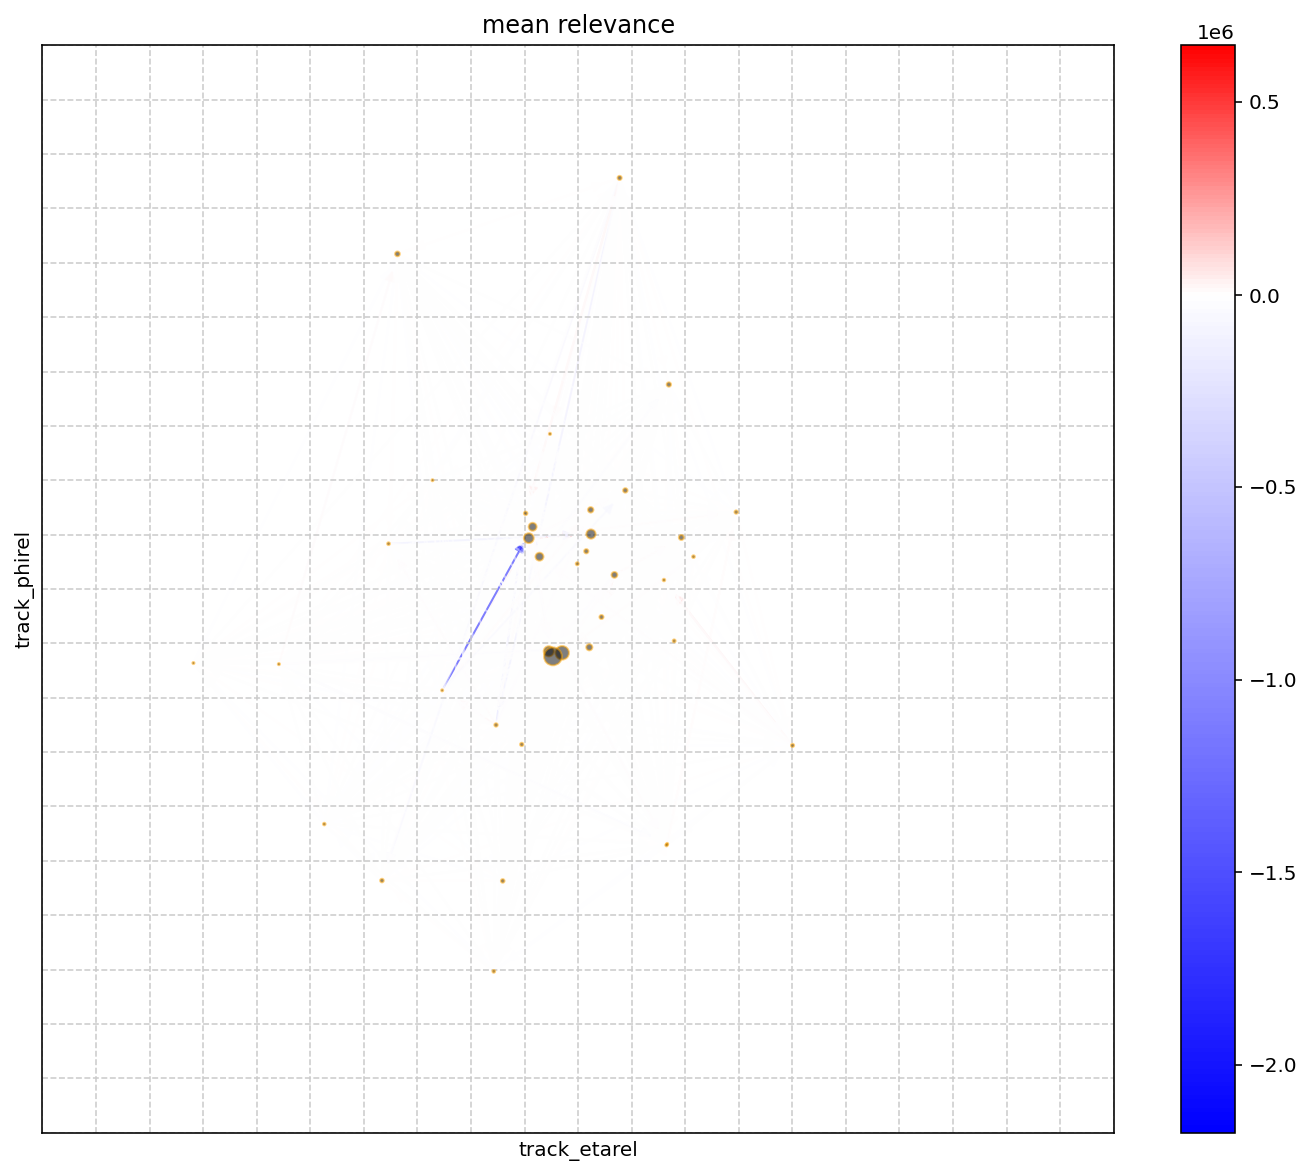

In [106]:
plot_rel(g,R["edge_mlp.0"].detach().numpy())